# CORD-19 citation network analysis

In this notebook, we build a bibliographic coupling citation network of the publications we could match in Dimensions, and perform clustering using the Leiden algorithm. We export cluster partition information, as well as global and local (cluster-specific) centrality measures to use in the regression analysis.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, time, pickle
import ujson as json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# dataset Dimensions: source of citation data

json_sources = "../cwts_covid/datasets_output/json_dimensions_cwts"

In [6]:
# build networks and node metadata
# this requires Dimensions data, downloaded following: https://github.com/CWTSLeiden/cwts_covid

from collections import OrderedDict
import sys

metadata = list()
metadata_dict = dict()
citations = OrderedDict()
total_publications = 0

for root, dirs, files in os.walk(json_sources):
    for f in files:
        try:
            all_data = codecs.open(os.path.join(root,f)).read()
        except:
            continue
        for line in all_data.split("\n"):
            total_publications += 1
            if line:
                try:
                    data = json.loads(line)
                    if "references" in data.keys() and len(data["references"])>0: # filter out papers without outbound citations
                        title = ""
                        year = ""
                        doi = ""
                        pmid = ""
                        d_id = ""
                        times_cited = ""
                        journal = ""
                        if "title" in data.keys() and data["title"]:
                            title = data["title"].replace('"',"")
                        if "journal" in data.keys() and "title" in data["journal"].keys() and data["journal"]["title"]:
                            jorunal = data["journal"]["title"]
                        if "year" in data.keys() and data["year"]:
                            year = str(data["year"])
                        if "doi" in data.keys() and data["doi"]:
                            doi = data["doi"]
                        if "pmid" in data.keys() and data["pmid"]:
                            doi = str(data["pmid"])
                        if "id" in data.keys() and data["id"]:
                            d_id = str(data["id"])
                        if "times_cited" in data.keys():
                            times_cited = str(data["times_cited"])
                        metadata.append((d_id,'"'+title+'"',year,'"'+doi+'"',pmid,'"'+journal+'"',times_cited))
                        metadata_dict[d_id] = {"title":title,"year":year,"doi":doi,"journal":journal,"times_cited":times_cited,
                                                    "pmid":pmid,"d_id":d_id}
                        citations[data["id"]] = data["references"]
                except ValueError:
                    print("Could not convert data.")
                except:
                    print(line)
                    continue

In [7]:
len(citations)

118214

In [8]:
total_publications

150765

In [9]:
# create bibc network
# this is a super naive method, and takes a while

bibc_edge_list = list()
items = [(k,v) for k,v in citations.items()]

for n,(k1,v1) in tqdm(enumerate(items)):
    for k2,v2 in items[n+1:]:
        edge_weight = len(set(v2).intersection(set(v1))) / len(set(v2).union(set(v1))) # fractional edge weight
        if edge_weight > 0:
            bibc_edge_list.append((k1,k2,str(edge_weight)))

In [10]:
# export in csv (optional)

with open("data/bib_coupling_edgelist_norm.csv","w") as f:
    f.write("Source,Target,Weight\n")
    for edge in bibc_edge_list:
        #if float(edge[2])>1:
        f.write(",".join(edge)+"\n")

In [11]:
with open("data/bib_coupling_nodelist.csv","w") as f:
    f.write("ID,Title,Year,DOI,PMID,Journal,Times_cited\n")
    for node in metadata:
        f.write(",".join(node)+"\n")

In [12]:
len(bibc_edge_list)

70091752

In [13]:
weight_list = [float(x[2]) for x in bibc_edge_list if float(x[2])>0]

In [14]:
np.median(weight_list)

0.021739130434782608

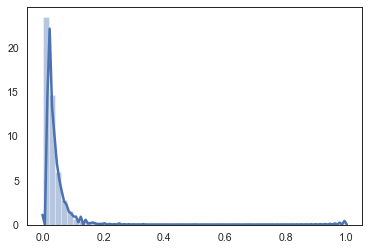

In [15]:
sns.distplot(weight_list)

In [16]:
# create an igraph graph

import igraph as ig
ig.set_random_number_generator(random.seed(seed))

In [17]:
g = ig.Graph(directed=False)

In [18]:
edges = [(int(k[0].replace("pub.","")),int(k[1].replace("pub.",""))) for k in bibc_edge_list]
nodes = list(set([k[0] for k in edges]).union(set([k[1] for k in edges])))
weights = [float(k[2]) for k in bibc_edge_list]

In [19]:
# mapping of nodes to identifiers

node_map = {k:n for n,k in enumerate(nodes)}
edges_int = [(node_map[k[0]],node_map[k[1]]) for k in edges]
nodes_int = [node_map[k] for k in nodes]

In [20]:
len(node_map)

115116

In [21]:
"There are "+str(len(citations)-len(node_map))+" disconnected publications (with references)"

'There are 3098 disconnected publications (with references)'

In [22]:
inverse_node_map = {n:k for k,n in node_map.items()}

In [23]:
# add nodes and edges

g.add_vertices(nodes_int)
g.add_edges(edges_int)
g.es["weight"] = weights
g.vs["weight"] = 1
g.vs["dimensions_id"] = nodes

In [24]:
# clustering 
import leidenalg as la

In [25]:
h = g.components(mode='weak').giant()

In [26]:
len(h.vs)

114829

In [27]:
# 0.05 seems to find a relatively high modularity and reasonable sized clusters. Lowering it brings up one or two large clusters.

partition = la.find_partition(h, la.CPMVertexPartition, resolution_parameter = 0.05)

In [28]:
partition.quality()

86016459.00001101

In [29]:
partition.q

0.34600157440217927

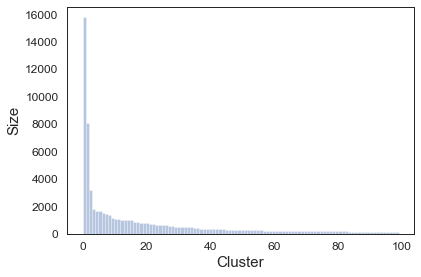

In [30]:
# distribution of the size of clusters

b = sns.distplot([x for x in partition.membership if x<100], norm_hist=False, kde=False, bins=100)
b.set_xlabel("Cluster",fontsize=15)
b.set_ylabel("Size",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb4_cluster_size_distr.pdf")

In [31]:
from collections import Counter

c = Counter(partition.membership)

In [32]:
len(c)

6187

In [33]:
c.most_common(15)

[(0, 15749),
 (1, 8034),
 (2, 3205),
 (3, 1816),
 (4, 1669),
 (5, 1619),
 (6, 1522),
 (7, 1418),
 (8, 1344),
 (9, 1153),
 (10, 1083),
 (11, 1042),
 (12, 1014),
 (13, 1008),
 (14, 981)]

In [34]:
cluster_sizes = {c:s for c,s in c.most_common()}

In [35]:
# add note attributes and calculate indicators. This takes some time to compute

In [36]:
h.vs['cluster_id'] = partition.membership
h.vs['cluster_above_threshold'] = False
h.vs['cluster_size'] = [cluster_sizes[x] for x in partition.membership]

In [37]:
h.vs['global_degree'] = h.degree()

In [38]:
h.vs['global_pagerank'] = h.pagerank(directed=False, weights='weight')

In [39]:
# using a cutoff here
#h.vs['global_closeness'] = h.closeness(weights='weight')

In [40]:
# cluster-specific indicators
h.vs['local_degree'] = np.nan
h.vs['local_pagerank'] = np.nan
#h.vs['local_closeness'] = np.nan

In [47]:
threshold = 300 # we only calculate indicators for nodes in clusters of size equal of greater than this threshold

# we pick a treshold to consider > 50% of the nodes
sum([x[1] for x in c.most_common() if x[1]>=threshold])/len(h.vs)

0.507075738707121

In [48]:
for cluster in c.most_common():
    c_id = cluster[0]
    c_size = cluster[1]
    if c_size >= threshold:
        t = partition.subgraph(c_id)
        t.vs['local_degree'] = t.degree()
        t.vs['local_pagerank'] = t.pagerank(directed=False, weights='weight')
        for v in t.vs:
            h.vs.find(dimensions_id=v['dimensions_id'])['local_degree'] = v['local_degree']
            h.vs.find(dimensions_id=v['dimensions_id'])['local_pagerank'] = v['local_pagerank']
            h.vs.find(dimensions_id=v['dimensions_id'])['cluster_above_threshold'] = True

In [49]:
# create and export a data frame
df_network = pd.DataFrame.from_dict({"dimensions_id": ["pub."+str(i) for i in h.vs['dimensions_id']],
                                     "network_cluster_id": h.vs['cluster_id'],
                                     "network_cluster_above_threshold": h.vs['cluster_above_threshold'],
                                     "network_cluster_size": h.vs['cluster_size'],
                                     "network_global_degree": h.vs['global_degree'],
                                     "network_global_pagerank": h.vs['global_pagerank'],
                                     "network_local_degree": h.vs['local_degree'],
                                     "network_local_pagerank": h.vs['local_pagerank']})
df_network.to_csv("data/df_network.csv", index=False, compression="gzip")

In [50]:
# graph of clusters (optional)

H = partition.cluster_graph(combine_vertices={'weight': 'sum'},
                                                 combine_edges={'weight': 'mean'})
H.write("data/network_of_clusters.graphml",format="graphml")

### Plots

In [2]:
# you can select here if to use an LDA or a CTM topic model
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
#df_topic_intensity = pd.read_csv("data/df_topic_intensity_ctm.csv", compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")
df_network = pd.read_csv("data/df_network.csv", compression="gzip")

In [3]:
df_topic_intensity.head()

,tm_coronaviruses,tm_epidemics,tm_ph,tm_mbi,tm_clinical_medicine,pub_id
0,0.335269,0.091129,0.111784,0.0,0.457265,0
1,0.299387,0.000000,0.198364,0.0,0.422208,1
2,0.000000,0.000000,0.953206,0.0,0.000000,2
3,0.000000,0.141524,0.674861,0.0,0.165509,3
4,0.000000,0.676764,0.307801,0.0,0.000000,4


In [4]:
df_topic_intensity.columns

Index(['tm_coronaviruses', 'tm_epidemics', 'tm_ph', 'tm_mbi',
       'tm_clinical_medicine', 'pub_id'],
      dtype='object')

In [5]:
topic_labels = ['tm_coronaviruses', 'tm_epidemics', 'tm_ph', 'tm_mbi',
       'tm_clinical_medicine']

In [6]:
tm_names = {"Coronaviruses": "tm_coronaviruses",
    "Epidemics": "tm_epidemics",
    "Public health": "tm_ph",
    "Molecular biology and immunology": "tm_mbi",
    "Clinical medicine": "tm_clinical_medicine"}
topic_labels = [x for x in tm_names.keys()]
reverse_tm_names = {x:y for y,x in tm_names.items()}
df_topic_intensity.rename(columns=reverse_tm_names,inplace=True)

In [7]:
df_embeddings = df_network.merge(df_joined_all[["pub_id","dimensions_id","in_wikipedia","title","publication_year"]], how="inner", left_on="dimensions_id", right_on="dimensions_id")

In [8]:
df_embeddings.shape

(108213, 12)

In [9]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")

In [10]:
df_topic_intensity.shape

(152247, 6)

In [11]:
df_embeddings.shape

(105915, 17)

In [12]:
df_embeddings.head()

,dimensions_id,network_cluster_id,network_cluster_above_threshold,network_cluster_size,network_global_degree,network_global_pagerank,network_local_degree,network_local_pagerank,pub_id,in_wikipedia,title,publication_year,Coronaviruses,Epidemics,Public health,Molecular biology and immunology,Clinical medicine
0,pub.1121976320,1075,False,12,60,0.000003,NaN,NaN,137626,False,An Exploration of Machine Learning Methods for...,2019.0,0.00000,0.328873,0.397463,0.037389,0.232290
1,pub.1103626240,36,True,418,320,0.000005,136.0,0.002279,65622,False,Molecularly specific detection of bacterial li...,2018.0,0.00000,0.069453,0.093479,0.506221,0.321498
2,pub.1049624581,23,True,655,48,0.000005,40.0,0.000637,103417,False,Hemodynamic-morphologic discriminants for intr...,2011.0,0.00000,0.542807,0.064618,0.000000,0.389494
3,pub.1026031634,2,True,3205,839,0.000009,567.0,0.000303,116401,False,Clinical Presentation and Birth Outcomes Assoc...,2016.0,0.48604,0.056072,0.037600,0.019100,0.397733
4,pub.1124597780,48,False,275,224,0.000003,NaN,NaN,111089,False,"PfSWIB, a potential chromatin regulator for va...",2020.0,0.00000,0.196043,0.035244,0.717387,0.040151


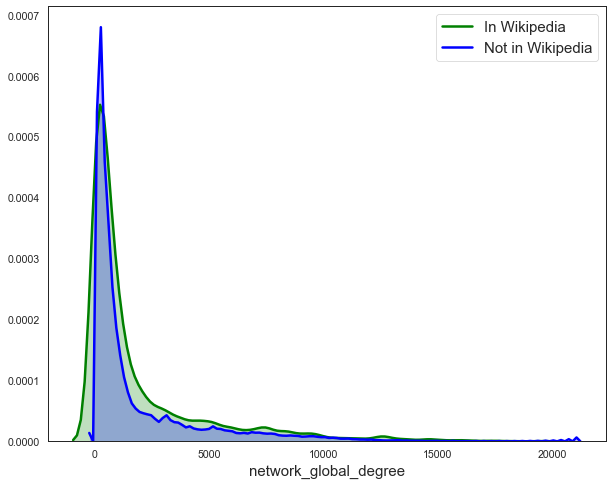

In [63]:
# distribution of centralities for papers cited from Wikipedia or not

which_centrality = "network_global_degree"

plt.figure(figsize=(10,8))
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==True][which_centrality].values, color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==False][which_centrality].values, color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("%s"%which_centrality,fontsize=15)
plt.savefig("figures/nb4_%s_in_wiki.pdf"%which_centrality)

In [64]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [13]:
threshold = 300 #see above

In [18]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()
below_threshold_size = 0
below_threshold_coverage = 0
local_threshold = threshold
#threshold = 500

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for cl in list(set(df_embeddings.network_cluster_id.to_list())):
    cl_size = df_embeddings[df_embeddings.network_cluster_id == cl].shape[0]
    inw = df_embeddings[(df_embeddings.in_wikipedia==True)&(df_embeddings.network_cluster_id==cl)].shape[0]
    if cl_size>=threshold:
        coverage = inw/cl_size
        cluster_coverage.append(coverage)
        cluster_size.append(cl_size)
        cluster_number.append(cl)
    else:
        below_threshold_coverage += inw
        below_threshold_size += cl_size
#cluster_coverage.append(below_threshold_coverage/below_threshold_size)
#cluster_size.append(below_threshold_size)
#cluster_number.append(-1)

In [26]:
len(cluster_coverage)

41

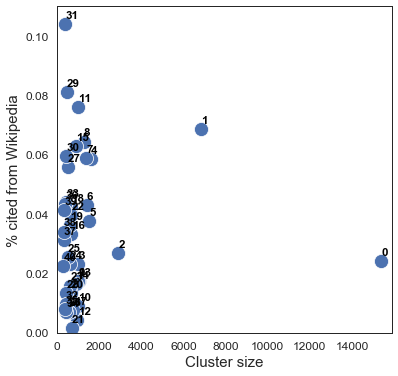

In [21]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in cluster_number:
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.11))
plt.xlim((0,max(cluster_size)+500))
#plt.legend(fontsize=15)
plt.tick_params(labelsize=12)
plt.ylabel("% cited from Wikipedia",fontsize=15)
plt.xlabel("Cluster size",fontsize=15)
plt.savefig("figures/nb4_cluster_size_vs_wiki_coverage_%d_no_max.pdf"%local_threshold)

In [43]:
which_cluster = 31

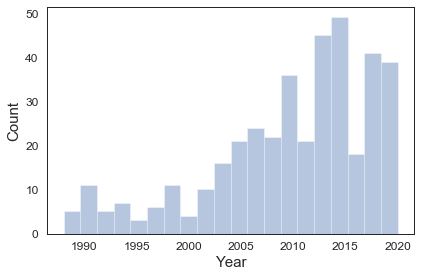

In [44]:
sns.distplot(df_embeddings[df_embeddings.network_cluster_id == which_cluster].publication_year, bins=20, kde=False)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
#plt.savefig("figures/nb4_cluster_%d_yeardistr.pdf"%(which_cluster))

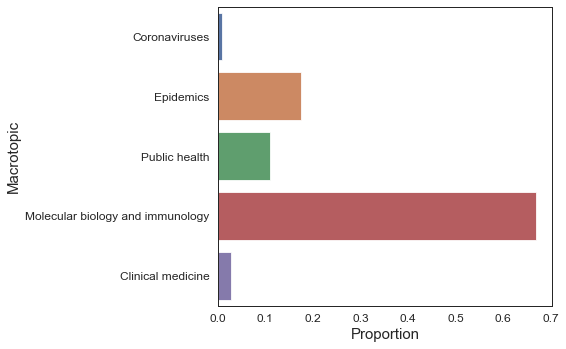

In [45]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.network_cluster_id == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("figures/nb4_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [46]:
# examples of central papers in a cluster

df_embeddings[["dimensions_id","network_cluster_id","network_cluster_size","network_global_degree","network_global_pagerank","title","publication_year"]][df_embeddings.network_cluster_id==which_cluster].sort_values("network_global_pagerank",ascending=False).head(20)

,dimensions_id,network_cluster_id,network_cluster_size,network_global_degree,network_global_pagerank,title,publication_year
8962,pub.1033411825,31,462,1176,0.000013,Characterization of the frameshift signal of E...,2005.0
61987,pub.1020049797,31,462,879,0.000013,The role of RNA pseudoknot stem 1 length in th...,1999.0
101359,pub.1041739343,31,462,712,0.000013,Pseudoknot-Dependent Programmed —1 Ribosomal F...,2009.0
100543,pub.1006608266,31,462,1010,0.000013,The stimulatory RNA of the Visna-Maedi retrovi...,2008.0
49617,pub.1008977174,31,462,1553,0.000013,Transactivation of programmed ribosomal frames...,2014.0
100225,pub.1024956862,31,462,864,0.000012,A Genome-Wide Analysis of RNA Pseudoknots That...,2013.0
53562,pub.1000083772,31,462,826,0.000012,Identification and analysis of the gag-pol rib...,1992.0
62079,pub.1049934732,31,462,762,0.000011,"V, 2.Ribosomal frameshifting in astroviruses",2004.0
102514,pub.1052229334,31,462,502,0.000011,An intermolecular RNA triplex provides insight...,2009.0
104115,pub.1028642862,31,462,895,0.000011,The many paths to frameshifting: kinetic model...,2010.0
